# Image degradation of high-field MRI to ultra-low-field MRI

This notebook presents the workflow and the results of the degradation of a high-field MRI dataset containing 3T images of newborn brains. The dataset has been filtered to only use the healthy subjects under 1 month old. The images are degraded to simulate the acquisition of the same images at ultra-low-field MRI. The dataset is first converted to the BIDS format, then the degradation is performed by changing the resolution and adding noise. 

## Converting the dataset to BIDS format

The formatting is done by using the script bids_conversion.py made specifically to convert the dataset found at https://zenodo.org/records/6556135.
The script demands as input the path to the downloaded dataset and the path to output the new BIDS dataset.

In [33]:
!python3  ./bids_conversion.py --path_input /Users/amahlig/Documents/Maitrise/IRM/Datasets/zenodo_upload --path_output /Users/amahlig/Documents/Maitrise/Cours/GBM6953EE-Brainhack/basel_bids

## Degrading the images

To degrade the images, it is first necessary to manually select a region of interest inside the white matter of each brain images from the original dataset. The ROI have been defined as 9 pixels square using FSL, then saved as t2_mask.nii.gz files in each subject folder.
It is then possible to use the degradation.py script that call the calcul_snr.py script to carry out the degradation.
This script takes as input the path to the new BIDS dataset and the path to the masks, which should be the same as the path_input defined earlier.

In [34]:
!python3 ./degradation.py --path_dataset /Users/amahlig/Documents/Maitrise/Cours/GBM6953EE-Brainhack/basel_bids --path_mask /Users/amahlig/Documents/Maitrise/IRM/Datasets/zenodo_upload

 Visualizing one of the initial high-field T2w image from the dataset

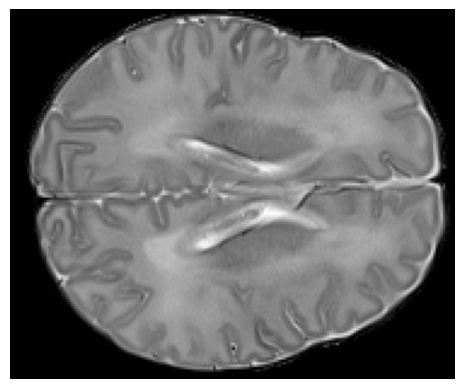

In [88]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load the image
img = nib.load('/Users/amahlig/Documents/Maitrise/Cours/GBM6953EE-Brainhack/basel_bids/'
               'sub-0006/anat/sub-0006_T2w.nii.gz')
data = img.get_fdata()

# Display a slice of the image
plt.imshow(data[:, :, 18], cmap='gray')
plt.axis('off')
plt.show()

Visualizing the corresponding degraded image

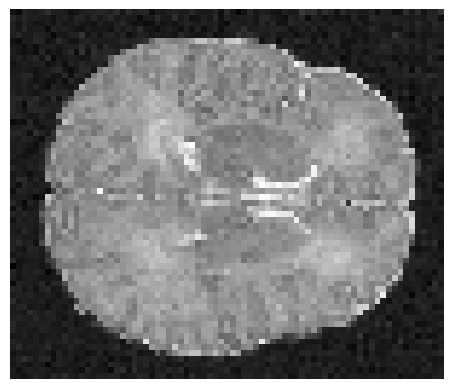

In [80]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load the image
img = nib.load('/Users/amahlig/Documents/Maitrise/Cours/GBM6953EE-Brainhack/basel_bids/'
               'derivatives/simulated_low-field/sub-0006/anat/sub-0006_T2w_simulated_low-field.nii.gz')
data = img.get_fdata()

# Display a slice of the image
plt.imshow(data[:, :, 12], cmap='gray')
plt.axis('off')
plt.show()

The degraded T1w and T2w images of each subject will be found in the new BIDS folder under derivatives/simulated_low-fied.

## SNR comparison
A comparison of the initial and degraded SNR of the T1w and T2w images can be found in the plot below.

In [35]:
import os
import csv
from calcul_snr import calcul_snr
import matplotlib.pyplot as plt
import pandas as pd
import ptitprince as pt
import numpy as np
import warnings

In [36]:
path_dataset = '/Users/amahlig/Documents/Maitrise/Cours/GBM6953EE-Brainhack/basel_bids/'
path_mask = '/Users/amahlig/Documents/Maitrise/IRM/Datasets/zenodo_upload/'

# Create a list of the participants with a normal diagnosis and age 0
participants = []
with open(os.path.join(path_dataset, 'participants.tsv'), 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for line in reader:
        if 'sub-' in line[0]:
            if line[2] == 'normal' and line[1] == '0':
                if line[0] not in ['sub-0645', 'sub-0672', 'sub-0841']: # These subjects have artefacts in their images.
                    participants.append(line[0])

In [37]:
# Retrieve the SNR of the initial and degraded images of the participants
warnings.filterwarnings('ignore', category=RuntimeWarning)

snr_init1 = calcul_snr(path_dataset, path_mask, participants)[0] 
snr_init2 = calcul_snr(path_dataset, path_mask, participants)[1] 

snr_deg1 = calcul_snr(path_dataset, path_mask, participants, True)[0] 
snr_deg2 = calcul_snr(path_dataset, path_mask, participants, True)[1] 
std_deg1 = calcul_snr(path_dataset, path_mask, participants, True)[2]
std_deg2 = calcul_snr(path_dataset, path_mask, participants, True)[3]

In [38]:
## Creating the SNR figure

# Create the dataframe
df_init1 = pd.DataFrame({
    'SNR': snr_init1,
    'State': 'Initial',
    'Type': 'T1w'
})

df_init2 = pd.DataFrame({
    'SNR': snr_init2,
    'State': 'Initial',
    'Type': 'T2w'
})

df_deg1 = pd.DataFrame({
    'SNR': snr_deg1,
    'State': 'Degraded',
    'Type': 'T1w'
})

df_deg2 = pd.DataFrame({
    'SNR': snr_deg2,
    'State': 'Degraded',
    'Type': 'T2w'
})

df = pd.concat([df_init1, df_init2, df_deg1, df_deg2], ignore_index=True)

# Eliminate rows with missing or incorrect values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df = df[df['SNR'] <= 100]

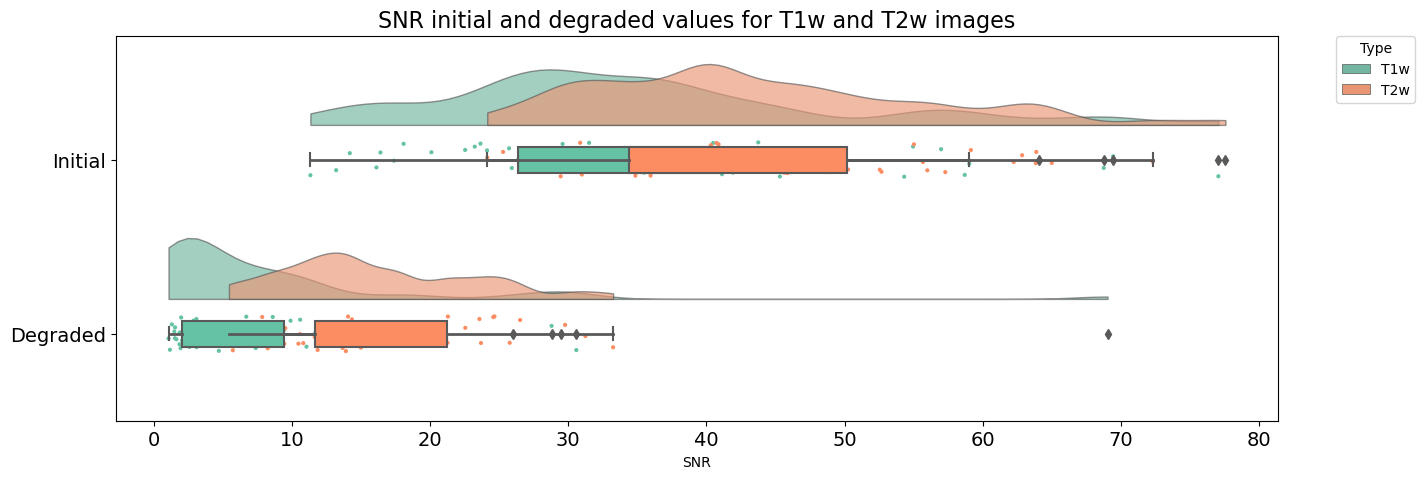

In [39]:
# Create the raincloud plot
ort, dhue, pal, sigma = 'h', 'Type', 'Set2', .2
f, ax = plt.subplots(figsize=(15, 5))
ax = pt.RainCloud(x='State', y='SNR', hue=dhue, data=df, palette=pal, bw=sigma,
                  width_viol=.7, ax=ax, orient=ort, alpha=.65)
ax.set_ylabel('')
plt.title("SNR initial and degraded values for T1w and T2w images", fontsize=16) 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 
plt.show()